# Comparing WT and ALE variants
---

In [1]:
import sys
sys.path.append('../../../src/')
import re
import pandas as pd
import os
import torch
import esm
from proteusAI.ML.plm import *
from proteusAI.io_tools import *
from scipy.stats import pearsonr
from proteusAI.data.pdb import show_pdb
import seaborn as sns

# Initialize a dictionary to map amino acids to their index in the alphabet
alphabet = alphabet.to_dict()

In [2]:
# Load the data
ale_data_path = "../ind_chem_tol_ai-master/aledb_snp_df.csv"
wt_data_path = "../ind_chem_tol_ai-master/all_sub_df.csv"
ale_data = pd.read_csv(ale_data_path)
wt_data = pd.read_csv(wt_data_path)
wt_data = wt_data[wt_data['AA seq change'] != '*'].reset_index().drop('index', axis=1)
wt_data = wt_data[wt_data['mutation effect'] != 'synonymous substitution'].reset_index().drop('index', axis=1)

fasta_path = "../ind_chem_tol_ai-master/data/fastas/"
gene_name_pattern = re.compile(r"GN=([^ ]*)")

names, seqs = load_all_fastas(fasta_path)
names = [gene_name_pattern.search(n).group(1) for n in names if gene_name_pattern.search(n)]

substitutions = []
for i, row in wt_data.iterrows():
    wt_aa = row['AA ref seq']
    change = row['AA seq change']
    pos = row['AA pos']
    sub = str(wt_aa) + str(pos) + str(change)
    substitutions.append(sub)
    
wt_data['substitution'] = substitutions

In [3]:
ale_data

,gene,substitution,variant source,conditions
0,rho,G61E,ALEdb,"{'temperature': '42 celsius', 'carbon-source':..."
1,mreB,E346A,ALEdb,"{'temperature': '37 celsius', 'carbon-source':..."
2,rho,K417I,ALEdb,"{'temperature': '37 celsius', 'carbon-source':..."
3,rho,I382F,ALEdb,"{'temperature': '37 celsius', 'carbon-source':..."
4,rpoA,T285I,ALEdb,"{'temperature': '37 celsius', 'carbon-source':..."
...,...,...,...,...
85,rpoA,G36D,ALEdb,"{'temperature': '37 celsius', 'carbon-source':..."
86,rpoA,D199Y,ALEdb,"{'temperature': '37 celsius', 'carbon-source':..."
87,rpoA,G36D,ALEdb,"{'temperature': '37 celsius', 'carbon-source':..."
88,rpoA,G36D,ALEdb,"{'temperature': '37 celsius', 'carbon-source':..."


In [4]:
wt_data

,AA pos,mutation type,mutation effect,mutation source,AA ref seq,AA seq change,gene,substitution
0,233,SUB,nonsynonymous substitution,ALEdb,D,G,metJ,D233G
1,36,SUB,nonsynonymous substitution,ALEdb,G,C,metJ,G36C
2,38,SUB,nonsynonymous substitution,ALEdb,T,A,metJ,T38A
3,306,SUB,nonsynonymous substitution,ALEdb,V,A,metJ,V306A
4,295,SUB,nonsynonymous substitution,ALEdb,L,F,metJ,L295F
...,...,...,...,...,...,...,...,...
709,128,substitution,nonsynonymous substitution,WT alleleome,R,C,rho,R128C
710,365,substitution,nonsynonymous substitution,WT alleleome,T,S,rho,T365S
711,221,substitution,nonsynonymous substitution,WT alleleome,R,C,rho,R221C
712,87,substitution,nonsynonymous substitution,WT alleleome,R,C,rho,R87C


In [10]:
def parse_substitution(substitution):
    match = re.match(r"([A-Za-z])(\d+)([A-Za-z])", substitution)
    if match:
        return match.groups()
    return None, None, None

def parse_mmp_values(data, vs="average"):
    names = set(data['gene'].to_list())
    mmp_dict = {n: torch.load(f"../results/01_initial_computations/{n}/{n}_prob_dist.pt", map_location="cpu") for n in names}

    # Create lists to store the mmp values of the substituted amino acids and the sum of mmp values of all other amino acids
    wt_probs = [None for i in range(len(data))]
    mt_probs = [None for i in range(len(data))]
    mmp_values = [None for i in range(len(data))]

    for index, row in data.iterrows():
        gene = str(row['gene'])
        wildtype_aa, position, substitute_aa = parse_substitution(row["substitution"])
        if wildtype_aa and position and substitute_aa:
            position = int(position) - 1  # Convert to 0-indexed
            substitute_aa_index = alphabet[substitute_aa]  # Get the index of the substituted amino acid
            wildtype_aa_index = alphabet[wildtype_aa]

            # Get the mmp value of the substituted amino acid
            try:
                p_mutant = mmp_dict[gene][0, position, substitute_aa_index].item()
                p_wt = mmp_dict[gene][0, position, wildtype_aa_index].item()
                mmp_value = math.log(p_mutant) - math.log(p_wt)
                mmp_values[index] = mmp_value
                wt_probs[index] = p_wt
                mt_probs[index] = p_mutant
            except:
                continue
            

    data['mmp'] = mmp_values
    data['p_wt'] = wt_probs
    data['p_mt'] = mt_probs
    return data

def parse_entropy_values(data, vs="average"):
    names = set(data['gene'].to_list())
    entropy_dict = {n: torch.load(f"../results/01_initial_computations/{n}/{n}_per_position_entropy.pt", map_location="cpu") for n in names}

    # Create lists to store the mmp values of the substituted amino acids and the sum of mmp values of all other amino acids
    entropy_values = [None for i in range(len(data))]

    for index, row in data.iterrows():
        gene = str(row['gene'])
        wildtype_aa, position, substitute_aa = parse_substitution(row["substitution"])
        if wildtype_aa and position and substitute_aa:
            position = int(position) - 1  # Convert to 0-indexed

            # Get the mmp value of the substituted amino acid
            try:
                entropy = entropy_dict[gene][0, position].item()
                entropy_values[index] = entropy
            except:
                continue
            

    data['entropy'] = entropy_values
    return data

In [11]:
ale_data = parse_mmp_values(ale_data)
wt_data = parse_mmp_values(wt_data)
ale_data = parse_entropy_values(ale_data)
wt_data = parse_entropy_values(wt_data)

In [19]:
ale_data

,gene,substitution,variant source,conditions,mmp,p_wt,p_mt,entropy
0,rho,G61E,ALEdb,"{'temperature': '42 celsius', 'carbon-source':...",-11.329698,0.999671,0.000012,0.005057
1,mreB,E346A,ALEdb,"{'temperature': '37 celsius', 'carbon-source':...",1.856350,0.022139,0.141695,3.475607
2,rho,K417I,ALEdb,"{'temperature': '37 celsius', 'carbon-source':...",-7.567365,0.748739,0.000387,1.340926
3,rho,I382F,ALEdb,"{'temperature': '37 celsius', 'carbon-source':...",-6.683246,0.580767,0.000727,1.375168
4,rpoA,T285I,ALEdb,"{'temperature': '37 celsius', 'carbon-source':...",-8.464903,0.524841,0.000111,1.534031
...,...,...,...,...,...,...,...,...
85,rpoA,G36D,ALEdb,"{'temperature': '37 celsius', 'carbon-source':...",-10.840666,0.982527,0.000019,0.136153
86,rpoA,D199Y,ALEdb,"{'temperature': '37 celsius', 'carbon-source':...",-10.176064,0.927817,0.000035,0.447046
87,rpoA,G36D,ALEdb,"{'temperature': '37 celsius', 'carbon-source':...",-10.840666,0.982527,0.000019,0.136153
88,rpoA,G36D,ALEdb,"{'temperature': '37 celsius', 'carbon-source':...",-10.840666,0.982527,0.000019,0.136153


In [12]:
wt_data

,AA pos,mutation type,mutation effect,mutation source,AA ref seq,AA seq change,gene,substitution,mmp,p_wt,p_mt,entropy
0,233,SUB,nonsynonymous substitution,ALEdb,D,G,metJ,D233G,NaN,NaN,NaN,NaN
1,36,SUB,nonsynonymous substitution,ALEdb,G,C,metJ,G36C,-0.858856,0.002597,0.001100,2.598534
2,38,SUB,nonsynonymous substitution,ALEdb,T,A,metJ,T38A,-4.686325,0.979205,0.009029,0.191044
3,306,SUB,nonsynonymous substitution,ALEdb,V,A,metJ,V306A,NaN,NaN,NaN,NaN
4,295,SUB,nonsynonymous substitution,ALEdb,L,F,metJ,L295F,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
709,128,substitution,nonsynonymous substitution,WT alleleome,R,C,rho,R128C,-7.966857,0.293941,0.000102,1.223760
710,365,substitution,nonsynonymous substitution,WT alleleome,T,S,rho,T365S,-6.723096,0.998742,0.001201,0.014435
711,221,substitution,nonsynonymous substitution,WT alleleome,R,C,rho,R221C,-11.938272,0.994736,0.000007,0.059601
712,87,substitution,nonsynonymous substitution,WT alleleome,R,C,rho,R87C,-11.421271,0.978386,0.000011,0.155304


# Masked marginal probability
---
The masked marginal probability scores a mutation by considering its probability relative to the wildtype amino acid.

It is calculated using the following equation

$\sum_{i\in M} \log p(x_i^{mt}|x_{\_M}) - \log p(x_i^{wt}|x_{\_M})$.

The probabilities for an amino acid at a position are computed by masking the position and passing the masked sequence through the LLM. The LLM then assignes probabilities for different amino acids at the masked position. In the above equation the probability for a different amino acid than observed in the wild type is denoted as $p(x_i^{mt}|x_{\_M})$ and the wildtype probability as $p(x_i^{wt}|x_{\_M})$. If multiple positions are mutated in a single variant the masked marginal probability is the sum over all scores for each position.

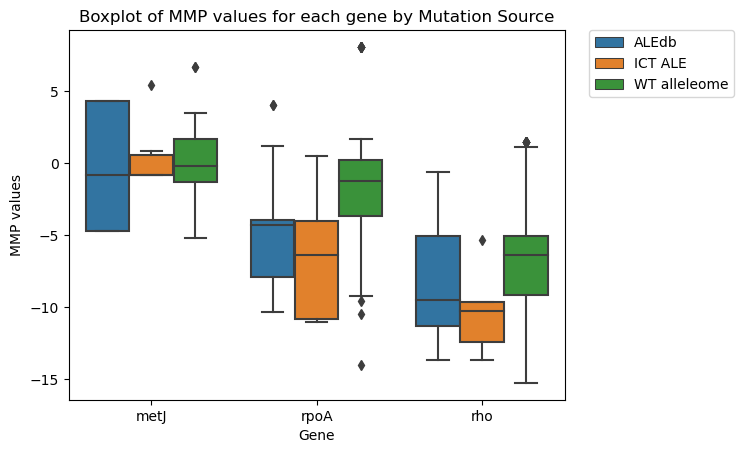

In [13]:
# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Generate the boxplot
sns.boxplot(x="gene", y="mmp", hue="mutation source", data=wt_data, ax=ax)

# Set the title and labels
ax.set_title('Boxplot of MMP values for each gene by Mutation Source')
ax.set_xlabel('Gene')
ax.set_ylabel('MMP values')

# Add legend outside of plot box
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Display the plot
plt.show()

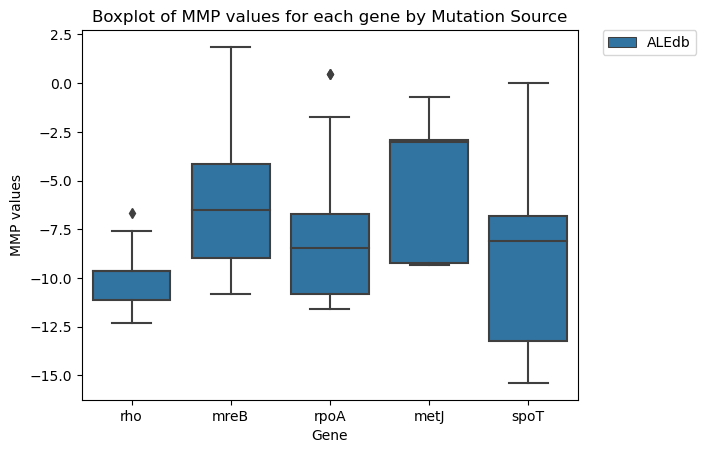

In [14]:
# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Generate the boxplot
sns.boxplot(x="gene", y="mmp", hue="variant source", data=ale_data, ax=ax)

# Set the title and labels
ax.set_title('Boxplot of MMP values for each gene by Mutation Source')
ax.set_xlabel('Gene')
ax.set_ylabel('MMP values')

# Add legend outside of plot box
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Display the plot
plt.show()

# Entropy
---
The per positions entropy is a computed as the $\log_2$ of the probabilities for every amino acid at each position. The entropy is high if no specific amino acid is preffered, and low if there is a strong preference for one or a few amino acids at a position.

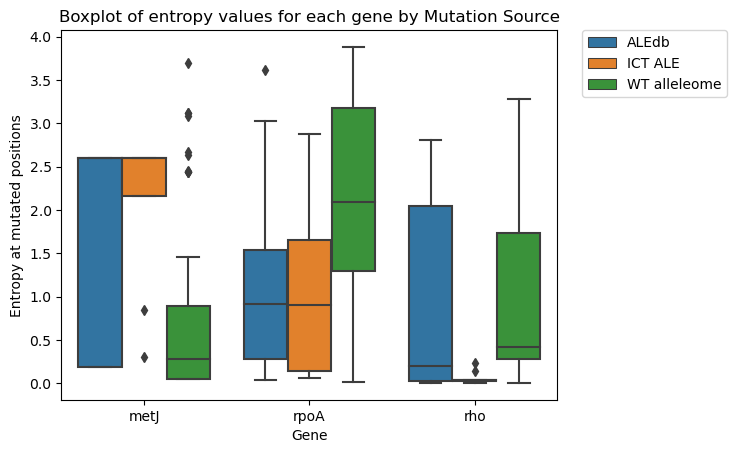

In [15]:
# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Generate the boxplot
sns.boxplot(x="gene", y="entropy", hue="mutation source", data=wt_data, ax=ax)

# Set the title and labels
ax.set_title('Boxplot of entropy values for each gene by Mutation Source')
ax.set_xlabel('Gene')
ax.set_ylabel('Entropy at mutated positions')

# Add legend outside of plot box
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Display the plot
plt.show()

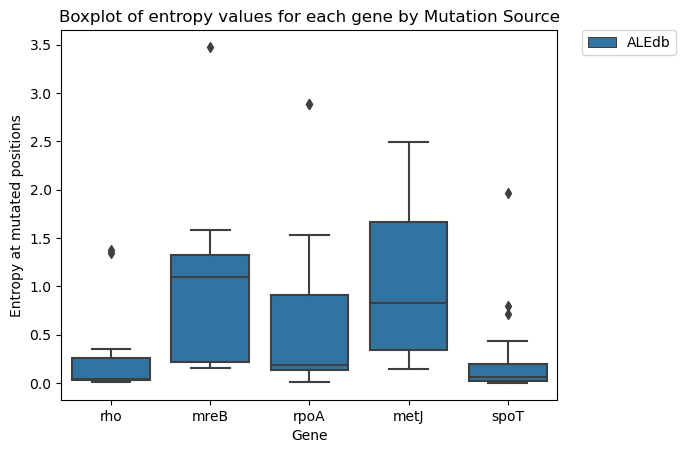

In [16]:
# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Generate the boxplot
sns.boxplot(x="gene", y="entropy", hue="variant source", data=ale_data, ax=ax)

# Set the title and labels
ax.set_title('Boxplot of entropy values for each gene by Mutation Source')
ax.set_xlabel('Gene')
ax.set_ylabel('Entropy at mutated positions')

# Add legend outside of plot box
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Display the plot
plt.show()

# Initial conclusion
---
There seems to be a preference for substitutions at lower entropy levels, which suggests, that the lower entropy positions are functionally more important. It is interesting that the mmp scores both for the wildtype and for the ALE-DB variants seem to be predominantly negative, which suggests, that the LLM estimates that the wildtype the mutations are unlikely compared to the wildtpye variant. It is also interesting to note that the ALE-DB variants seem to be more extreme than the wildtype allelome variants. This can be inferred from the comperatively lower mmp scores for the ALE-DB variants compared to the wildtype variants. My hypothesis is that extremeness observed in the ALE-DB stems from the difference in laboratory conditions compared to wildtype conditions.

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from itertools import combinations

def calculate_p_values(df):
    # Get unique genes and mutation sources
    genes = df['gene'].unique()
    mutation_sources = df['mutation source'].unique()

    # Initialize list to store results
    results = []

    for gene in genes:
        # Filter dataframe for each specific gene
        gene_df = df[df['gene'] == gene]

        # Iterate over pairs of mutation sources
        for mutation_source_1, mutation_source_2 in combinations(mutation_sources, 2):

            # Get mmp values for each mutation source
            mmp_values_1 = gene_df[gene_df['mutation source'] == mutation_source_1]['mmp']
            mmp_values_2 = gene_df[gene_df['mutation source'] == mutation_source_2]['mmp']

            # Only conduct test if both categories have data
            if len(mmp_values_1) > 0 and len(mmp_values_2) > 0:

                # Perform Mann-Whitney U test
                stat, p_value = mannwhitneyu(mmp_values_1, mmp_values_2, alternative='two-sided')

                # Append results
                mutation_sources_pair = f'{mutation_source_1} vs {mutation_source_2}'
                results.append([gene, mutation_sources_pair, p_value])

    # Create a dataframe for the results
    result_df = pd.DataFrame(results, columns=['gene', 'mutation_sources_pair', 'p_value'])
    return result_df


In [18]:
calculate_p_values(wt_data)

,gene,mutation_sources_pair,p_value
0,metJ,ALEdb vs ICT ALE,NaN
1,metJ,ALEdb vs WT alleleome,NaN
2,metJ,ICT ALE vs WT alleleome,NaN
3,rpoA,ALEdb vs ICT ALE,1.241623e-01
4,rpoA,ALEdb vs WT alleleome,7.327544e-08
5,rpoA,ICT ALE vs WT alleleome,6.492448e-06
6,rho,ALEdb vs ICT ALE,NaN
7,rho,ALEdb vs WT alleleome,NaN
8,rho,ICT ALE vs WT alleleome,4.753789e-04
